In [1]:
# 1) Imports & seeds
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [2]:
# 2) Load dataset (Kaggle CSV) or generate synthetic fallback
CANDIDATE_PATHS = [
    'Tesla.csv', 'TSLA.csv', 'tesla.csv', 'Tesla_Stock_Price.csv', 'TSLA_Stock_Price.csv',
    '/mnt/data/Tesla.csv', '/mnt/data/TSLA.csv'
]

CSV_PATH = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        CSV_PATH = p
        break

def generate_synthetic_tesla(n=800):
    dates = pd.date_range(start='2015-01-01', periods=n, freq='B')
    t = np.arange(n)
    trend = 200 + 0.05*t
    season = 5 * np.sin(2*np.pi*t/60)
    noise = np.random.normal(scale=2.0, size=n)
    open_price = trend + season + noise
    high = open_price + np.abs(np.random.normal(1.5, 0.5, size=n))
    low = open_price - np.abs(np.random.normal(1.5, 0.5, size=n))
    close = open_price + np.random.normal(0, 1.0, size=n)
    volume = np.random.randint(1_000_000, 10_000_000, size=n)
    return pd.DataFrame({'Date': dates, 'Open': open_price, 'High': high, 'Low': low, 'Close': close, 'Volume': volume})

if CSV_PATH:
    df = pd.read_csv(CSV_PATH)
    df.columns = [c.strip().title() for c in df.columns]
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        # try to detect date-like column
        for col in df.columns:
            if 'date' in col.lower() or 'timestamp' in col.lower():
                df['Date'] = pd.to_datetime(df[col])
                break
    # ensure required columns exist; if not, attempt to recover or synthesize proxies
    expected = ['Open','High','Low','Close','Volume']
    for col in expected:
        if col not in df.columns:
            if 'Close' in df.columns and col!='Volume':
                df[col] = df['Close'] + np.random.normal(0, 0.5, size=len(df))
            else:
                df[col] = np.random.normal(200, 5, size=len(df)) if col!='Volume' else np.random.randint(1_000_000, 10_000_000, size=len(df))
    df = df[['Date','Open','High','Low','Close','Volume']].copy()
    source_note = f"Loaded dataset from {CSV_PATH}"
else:
    df = generate_synthetic_tesla(n=800)
    source_note = "CSV not found - using synthetic data fallback."

df = df.sort_values('Date').reset_index(drop=True)
print(source_note)
df.head()


CSV not found - using synthetic data fallback.


,Date,Open,High,Low,Close,Volume
0,2015-01-01,200.993428,202.962570,199.584877,200.271691,4604724
1,2015-01-02,200.296114,201.538091,198.108676,200.472935,7818922
2,2015-01-05,202.434936,203.982996,201.257918,201.888255,7847575
3,2015-01-06,204.741145,206.010007,203.640741,204.469490,2151882
4,2015-01-07,201.765376,203.048128,200.506748,203.438829,7456182


In [3]:
# 3) Preprocess: features, target, scalers, chronological train/test split, framing sequences

FEATURES = ['Open','High','Low','Close','Volume']
TARGET = 'Open'       # we will predict next-day Open
LOOKBACK = 60         # input window (days)

# 3.1 Chronological split
data = df[['Date'] + FEATURES].dropna().reset_index(drop=True)
split_idx = int(len(data) * 0.8)
train_df = data.iloc[:split_idx].copy()
test_df  = data.iloc[split_idx:].copy()

# 3.2 Scale features (fit on train only) and scale target separately
scaler_X = MinMaxScaler()
scaler_X.fit(train_df[FEATURES])

scaler_y = MinMaxScaler()
scaler_y.fit(train_df[[TARGET]])  # keep as column vector for inverse_transform

# 3.3 Scaled DataFrames
train_X_scaled = pd.DataFrame(scaler_X.transform(train_df[FEATURES]), columns=FEATURES, index=train_df.index)
test_X_scaled  = pd.DataFrame(scaler_X.transform(test_df[FEATURES]), columns=FEATURES, index=test_df.index)

train_y_scaled = scaler_y.transform(train_df[[TARGET]]).ravel()  # 1D array
test_y_scaled  = scaler_y.transform(test_df[[TARGET]]).ravel()

# 3.4 Helper to create sequences (X: lookback steps of scaled features, y: next-day scaled target)
def make_sequences(features_scaled_df, target_scaled_array, lookback=60):
    X, y = [], []
    for i in range(lookback, len(features_scaled_df)-1):  # -1 because target is at i+1
        X.append(features_scaled_df.iloc[i-lookback:i].values)
        y.append(target_scaled_array[i+1])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 3.5 Training sequences (simple: from train scaled)
X_train, y_train = make_sequences(train_X_scaled, train_y_scaled, LOOKBACK)

# 3.6 Test sequences: we need continuity (use tail of train as context)
tail_ctx_X = train_X_scaled.iloc[-LOOKBACK:].copy()
tail_ctx_y = train_y_scaled[-LOOKBACK:]

test_combined_X = pd.concat([tail_ctx_X, test_X_scaled], axis=0).reset_index(drop=True)
test_combined_y = np.concatenate([tail_ctx_y, test_y_scaled], axis=0)

X_test, y_test = make_sequences(test_combined_X, test_combined_y, LOOKBACK)

print("Shapes -> X_train, X_test, y_train, y_test:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes -> X_train, X_test, y_train, y_test: (579, 60, 5) (159, 60, 5) (579,) (159,)


In [4]:
# 4) Build model factory (LSTM by default; switch with rnn_type)
def build_rnn_model(n_features, lookback, rnn_type='LSTM'):
    model = Sequential()
    if rnn_type.upper() == 'LSTM':
        model.add(LSTM(64, return_sequences=True, input_shape=(lookback, n_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(32))
    elif rnn_type.upper() == 'SIMPLERNN' or rnn_type.upper() == 'RNN':
        model.add(SimpleRNN(64, return_sequences=True, input_shape=(lookback, n_features)))
        model.add(Dropout(0.2))
        model.add(SimpleRNN(32))
    else:
        raise ValueError("rnn_type must be 'LSTM' or 'SimpleRNN'")
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # scaled output
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

n_features = len(FEATURES)
rnn_type = 'LSTM'   # <--- change to 'SimpleRNN' if you want
model = build_rnn_model(n_features, LOOKBACK, rnn_type=rnn_type)
model.summary()


C:\Users\RenuSingh\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 5) Train the model (early stopping; do NOT shuffle)
EPOCHS = 50
BATCH_SIZE = 32
VAL_SPLIT = 0.15

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    shuffle=False,
    verbose=1
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - loss: 0.0192 - mae: 0.1110 - val_loss: 0.0079 - val_mae: 0.0757
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0450 - mae: 0.1806 - val_loss: 0.0135 - val_mae: 0.0943
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0268 - mae: 0.1339 - val_loss: 0.0216 - val_mae: 0.1265
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.0103 - mae: 0.0814 - val_loss: 0.0087 - val_mae: 0.0757
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0098 - mae: 0.0795 - val_loss: 0.0065 - val_mae: 0.0661
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0095 - mae: 0.0782 - val_loss: 0.0061 - val_mae: 0.0641
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0095 - mae: 0.0792 - val_loss: 0.0062 - val_mae: 0.0645
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0092 - mae: 0.0761 - val_loss: 0.0073 - val_mae: 0.0698
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
Test MAE : 1.9460
Test RMSE: 2.3906
Test MAPE: 0.83%


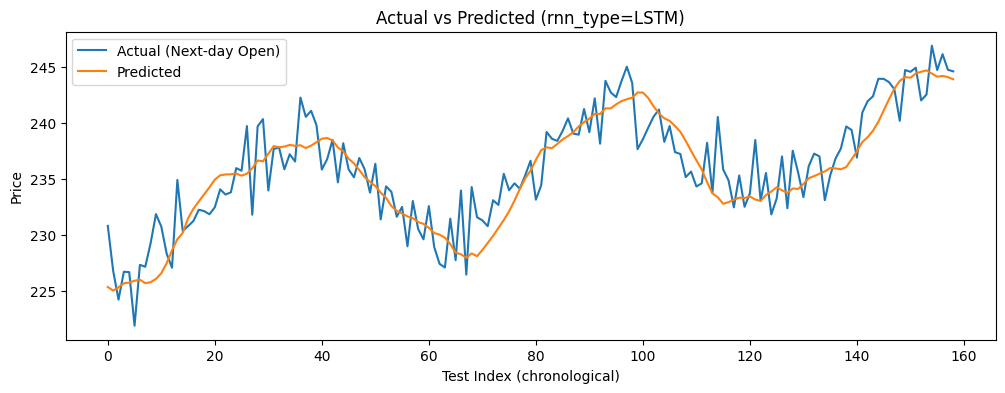

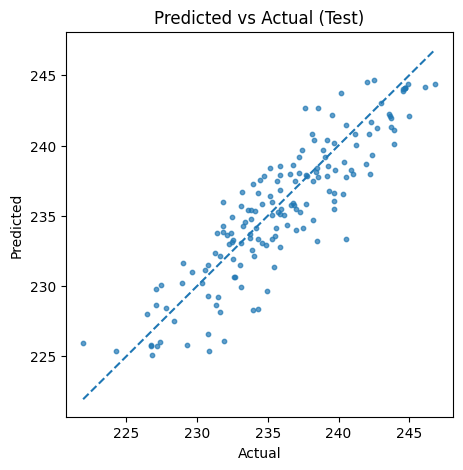

In [6]:
# 6) Evaluate on test set: predict, inverse-scale, compute MAE/RMSE/MAPE, and plots
y_pred_scaled = model.predict(X_test).ravel()

# invert scaling
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100.0

print(f"Test MAE : {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.2f}%")

# Plots: actual vs predicted (chronological)
plt.figure(figsize=(12,4))
plt.plot(y_true, label='Actual (Next-day Open)')
plt.plot(y_pred, label='Predicted')
plt.title(f'Actual vs Predicted (rnn_type={rnn_type})')
plt.xlabel('Test Index (chronological)')
plt.ylabel('Price')
plt.legend()
plt.show()

# Scatter plot: predicted vs actual
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.7)
min_v, max_v = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], '--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual (Test)')
plt.show()


In [7]:
# 7) Quick notes (printed)
print("Notes:")
print(" - If validation loss << train loss or vice versa, check overfitting or data leakage.")
print(" - To switch to SimpleRNN, set rnn_type = 'SimpleRNN' before building the model.")
print(" - For production: consider walk-forward validation, more features (indicators / markets), hyperparameter tuning.")


Notes:
 - If validation loss << train loss or vice versa, check overfitting or data leakage.
 - To switch to SimpleRNN, set rnn_type = 'SimpleRNN' before building the model.
 - For production: consider walk-forward validation, more features (indicators / markets), hyperparameter tuning.
